In [373]:
import numpy as np
import yaml
import matplotlib.pyplot as plt
import csv

In [374]:
with open(r'/Users/dl/Documents/GitHub/Turbopump/TCA/TCA_params.yaml') as file: ##CHANGED FOR DANIEL
		tca_params = yaml.safe_load(file)

In [375]:
# == Conversion between units ==
psi_into_pa = 6894.76 # Convert psi -> Pascal
meters_into_inches = 39.37 # Convert meters -> inches
degrees_into_rad = np.pi/180 # Convert degrees -> radians
lbm_into_kg = 0.453592 # Convert lbm -> kg
lbf_into_newton = 4.44822 # Convert lbf -> Newton
g0 = 9.81 # m/s^2

In [376]:
# == Desing Parameters (Change as needed) == 
mdot = tca_params['tca_throat_choked_flow']*lbm_into_kg #Total propellant mass flow rate [kg/s]
OF_Ratio = tca_params['oxidizer_fuel_ratio'] #Mixture ratio O/F 
rho_rp1 = 810 #RP1 Density [kg/m^3] at injector conditions
rho_lox = 1141 #LOX Density [kg/m^3] at injector conditions
Cd = tca_params['discharge_coefficient'] #Discharge coefficient

Pc = tca_params['tca_chamber_pressure']*psi_into_pa #Chamber stagnation pressure [Pa]
Pin = tca_params['incoming_pressure']*psi_into_pa #injector inlet pressure [Pa]
delta_P = Pin - Pc #Pressure drop across injector [Pa]


Length_chamber = tca_params['tca_chamber_length']/meters_into_inches #Combustion chamber length [m]
CombDiam = tca_params['tca_chamber_diameter']/meters_into_inches #chamber inner diameter [m]
throat_diameter = tca_params['tca_throat_diameter']/meters_into_inches #throat diameter [m]

num_holes_rp1_inj = tca_params['injector_number_of_holes_rp1'] #number of RP1 holes in injector faceplate
num_holes_lox_inj = tca_params['injector_number_of_holes_lox'] #number of LOX holes in injector faceplate

# == Injector Geometry Parameters ==
wall_thickness = tca_params['injector_plate_thickness'] #[m]
impinge_fraction = tca_params['impinge_fraction'] #streams will impinge at 2.2% of chamber length
distance_between_holes = tca_params['distance_between_holes'] #[m]
marginWall = tca_params['marginWall'] #clearance from outer RP1 jet to wall [m]
pairSpacing = tca_params['pairSpacing'] #spacing between mid-radii of FO pairs [m]

#MANIFOLD DESIGN
h_manifold = tca_params['h_manifold'] #m
dpFracMani = 0.09 #dp manifold ~9% of injector dp

#Friction factors and local loss coefficients
fOx = 0.01 #darcy friction factor LOX
fRP1 = 0.01 #darcy friction factor RP1
KOx = 1 #lumped local loss K LOX
KRP1 = 1 #lumped local loss K RP1
NinletsOx = 1 #number of LOX manifold inlets
NinletsRP1 = 1 #number of RP1 manifold inlets

In [377]:
mdot_kero = mdot/(1+OF_Ratio) #Fuel mass flow (RP-1)
mdot_lox = mdot*OF_Ratio/(1+OF_Ratio) #Oxidizer mass flow (LOX)
Nrings = 2 #Number of hole rings per propellant

This function distribute the total propellant mass flow among a specific set of injector holes
    mdot_propellant --- the total mass flow rate of that propelant [kg/s]
    number_holes --- number of holes of this specific type 
    total_number_of_holes --- total number of holes that share the propellant flow

In [378]:
def mdot_prop(mdot_propellant, number_holes, total_number_of_holes):
    mdot_propel = mdot_propellant * number_holes/(total_number_of_holes)
    mdot_per_hole = mdot_propel/number_holes
    return mdot_propel, mdot_per_hole

This function computes the required injector orifice diameter for a given mass flow 
    mdot_per_prop --- mass flow rate through this specific parth [kg/s]
    rho --- propellant density at injector conditions
    delta_pressure --- pressure drop across the orifice [psi]
    number_holes --- number of identical holes sharing this mass flow

In [379]:
def diameter(mdot_per_prop, rho, delta_pressure, number_holes): 
    #following the orifice flow model, and solving for the Area
    Total_area = mdot_per_prop/(Cd*np.sqrt(2*rho*delta_pressure))
    Area_per_hole = Total_area/number_holes
    d_hole = 2*np.sqrt(Area_per_hole/np.pi) 
    return d_hole

This function computes the ideal jet exit velocity through an injector orifice using Bernoulli's incompressible flow relation with a pressure drop
    delta_pressure_injector --- pressure drop across the injector 
    rho --- propellant density at injector conditions [kg/m^3]

In [380]:
def velocity(delta_pressure_injector, rho):
    velocity = np.sqrt((2*delta_pressure_injector)/rho)
    return velocity

This function determines the oxidizer injection angle (theta_ox) for a doublet impinging injector such that the post-impingement spray sheet forms a desired angle beta with respect to the chamber axis, for a given fuel injection angle theta_fuel. 

In [381]:
def solve_thetas(mdot_fuel, mdot_ox, v_fuel, v_ox, theta_fuel, beta_target_deg, 
                 theta_ox_min_deg=5.0, theta_ox_max_deg=80.0, dtheta_deg=0.05):
    theta_f_rad = theta_fuel*degrees_into_rad
    beta_target = beta_target_deg*degrees_into_rad
    p_f = mdot_fuel * v_fuel
    p_ox = mdot_ox * v_ox
    best_err = 1e12
    best_theta_ox_deg = None
    best_beta_deg = None 
    theta_ox_deg = theta_ox_min_deg
    while theta_ox_deg <= theta_ox_max_deg:
        theta_ox_rad = theta_ox_deg*degrees_into_rad
        px = p_ox*np.sin(theta_ox_rad) - p_f*np.sin(theta_f_rad)
        py = p_ox*np.cos(theta_ox_rad) + p_f*np.cos(theta_f_rad)
        R = px/py
        beta_res = np.arctan(R)
        err = abs(beta_res - beta_target)
        if err < best_err:
            best_err = err
            best_theta_ox_deg = theta_ox_deg
            best_beta_deg = beta_res/degrees_into_rad
        theta_ox_deg += dtheta_deg
    return best_beta_deg, best_theta_ox_deg

These functions compute the geometric relationships of a doublet impinging injection. Including Manifold Design

In [382]:
def compute_spacing_doublet(Lc, impingement_fraction, theta_fuel_deg, theta_ox_deg):
    #compute axial impingement location
    z_imp = Lc *impingement_fraction
    #converting jet angles into radians
    theta_f = theta_fuel_deg*degrees_into_rad
    theta_ox = theta_ox_deg*degrees_into_rad
    #Lateral displacement of each jet at the impingement plane:
    # x = z * tan(theta)
    d_imp_f = z_imp * (np.tan(theta_f))
    d_imp_ox = z_imp * (np.tan(theta_ox))
    #required injector-to-injector spacing for the jets to meet at z_imp
    d_fo = z_imp * (np.tan(theta_f) + np.tan(theta_ox))
    return z_imp, d_imp_f, d_imp_ox, d_fo

In [383]:
def dist(thickness, theta):
    theta_rad = theta*degrees_into_rad
    dist = thickness*(np.tan(theta_rad))
    return dist

In [384]:
def design_manifold(d_orifice, n_orifices, h, rho, m_dot):
    #Total exit area (orifices):
    A_exit = n_orifices * (np.pi*(d_orifice**2)/4)
    #required manifold cross-sectional area:
    #based on the 4:1 rule for pressure uniformity
    req_manifold_area = 4 * A_exit
    #geometry with rounded corners (r = h/4)
    r = h/6
    #area loss at the 4 corners compared to a perfect rectangle
    corner_area_loss = (r**2)*(4 - np.pi)
    w = (req_manifold_area + corner_area_loss)/h
    #manifold internal velocity
    v = m_dot/(rho*req_manifold_area)
    return A_exit, req_manifold_area, h, w, r, v

In [385]:
def calculate_manifold_pressure_drop(w, h, r, length, rho, mu, mdot, epsilon = 0.015):
    area = w*h - (4 - np.pi)*(r**2)
    perimeter = 2*(w + h - 4*r) + 2*np.pi*r
    #hydraulic diameter
    Dh = (4*area/perimeter)
    velocity = mdot/(rho*area)
    #reynolds number
    Re = (rho*velocity*Dh)/mu
    #friction factor (using the Haaland equation)
    if Re > 2300:
        rel_roughness = (epsilon/1000)/Dh
        f_inv_sqrt = -1.8 * np.log10(((rel_roughness/3.7)**1.11) + (6.9/Re))
        f = (1/f_inv_sqrt)**2
    else:
        f = 64/Re
    delta_P = f * (length/Dh) * (rho*velocity**2)/2
    delta_P_psi = delta_P / psi_into_pa
    return delta_P_psi

Compute total and per-hole mass flow for RP1 and LOX injection holes mdot_prop(...) distributes the propellant mass flow across the specified number of holes. 

In [386]:
mdot_rp1_inj, mdot_rp1_inj_per_hole = mdot_prop(mdot_kero, num_holes_rp1_inj, num_holes_rp1_inj)
mdot_lox_inj, mdot_lox_inj_per_hole = mdot_prop(mdot_lox, num_holes_lox_inj, num_holes_lox_inj) 

mdot_rp1_ring = mdot_rp1_inj / Nrings
mdot_lox_ring = mdot_lox_inj / Nrings

Computing injection velocity for each propellant.

In [387]:
v_lox = velocity(delta_P, rho_lox)
v_rp1 = velocity(delta_P, rho_rp1)

Compute the required orifice diameter for RP-1 and LOX jets using the orifice flow model. Each diameter is sized to pass the per-hole mass flow at the specified ΔP and fluid density.

In [388]:
diameter_inj_rp1 = diameter(mdot_rp1_inj, rho_rp1, delta_P, num_holes_rp1_inj)
diameter_inj_lox = diameter(mdot_lox_inj, rho_lox, delta_P, num_holes_lox_inj)

print(f"RP-1 injector hole diameter: {diameter_inj_rp1*1000:.2f} mm")
print(f"LOX injector hole diameter: {diameter_inj_lox*1000:.2f} mm")

RP-1 injector hole diameter: 1.04 mm
LOX injector hole diameter: 1.39 mm


Computes the LOX injection angle rquired so that the resultant post-impingement sheet angle matches the desired beta.

In [389]:
theta_rp1_deg = float(input("Fuel angle (deg): "))
beta_des = float(input("Enter an angle for the impingement (relative to vertical): "))
beta_res_deg, theta_lox_deg = solve_thetas(mdot_rp1_inj_per_hole, mdot_lox_inj_per_hole, v_rp1, v_lox, theta_rp1_deg, beta_des)

Impinging geometry check. Calculate impingement geometry using the final RP-1 and LOX angles:

In [390]:
z_imp, d_rp1, d_lox, d_fo_req = compute_spacing_doublet(Length_chamber, impinge_fraction, theta_rp1_deg, theta_lox_deg)

Distance between inner and outer orifices

In [391]:
dist_fuel = dist(wall_thickness, theta_rp1_deg)
dist_ox = dist(wall_thickness, theta_lox_deg)

MANIFOLD OUTPUTS

In [392]:
combRad = CombDiam / 2.0
radius_Ox = diameter_inj_lox / 2.0
radius_fuel = diameter_inj_rp1 / 2.0

# --- Anchor the outermost fuel ring near the wall (same idea as your original) ---
# Here we place the *fuel outer ring radius* such that the outer edge of the fuel hole
# is marginWall away from chamber wall.
Rf_outer = combRad - marginWall - radius_fuel

# --- Fuel inner ring is pairSpacing inward from fuel outer ring ---
Rf_inner = Rf_outer - pairSpacing

# --- Enforce F-F-O-O ordering by placing the oxidizer rings inside the fuel rings ---
# Impingement radial separation should be d_fo_req for each pair:
#   F_in  pairs with OX_in  ->  Rf_inner - ROx_inner = d_fo_req
#   F_out pairs with OX_out ->  Rf_outer - ROx_outer = d_fo_req
ROx_outer = Rf_outer - d_fo_req
ROx_inner = Rf_inner - d_fo_req

# --- Optional: sanity checks (leave these in while debugging) ---
if not (Rf_outer > Rf_inner > ROx_outer > ROx_inner):
    raise ValueError(
        "Failed to build F-F-O-O ordering (outside→inside):\n"
        f"Rf_outer={Rf_outer*1e3:.3f} mm, Rf_inner={Rf_inner*1e3:.3f} mm, "
        f"ROx_outer={ROx_outer*1e3:.3f} mm, ROx_inner={ROx_inner*1e3:.3f} mm"
    )
if ROx_inner <= 0:
    raise ValueError(
        "ROx_inner ended up <= 0 (rings collapse toward center). "
        "Reduce d_fo_req and/or pairSpacing, or increase chamber diameter."
    )

# Pack arrays as [inner, outer] for each propellant (your plotting/export expects this)
Rring_rp1 = np.array([Rf_inner, Rf_outer])
Rring_lox = np.array([ROx_inner, ROx_outer])

# Circumferences and path lengths (keep your existing logic)
circ_ox = 2*np.pi*Rring_lox
circ_rp1 = 2*np.pi*Rring_rp1

Lpath_ox = circ_ox / (2*NinletsOx)
Lpath_rp1 = circ_rp1 / (2*NinletsRP1)
Lpath_ox_avg = (Lpath_ox[0] + Lpath_ox[1]) / 2

dpInjOx = delta_P
dpInjRP1 = delta_P

mdot_lox_per_ring = mdot_lox_inj / Nrings
mdot_rp1_per_ring = mdot_rp1_inj / Nrings


In [393]:
# One LOX manifold feeding BOTH LOX rings
A_exit_ox, A_mani_ox, h_ox, w_ox, r_ox, v_mani_ox = design_manifold(
    diameter_inj_lox,
    num_holes_lox_inj,          # all LOX holes
    h_manifold,
    rho_lox,
    mdot_lox_inj                # all LOX flow
)

# One RP-1 manifold feeding BOTH RP-1 rings
A_exit_f, A_mani_f, h_f, w_f, r_f, v_mani_f = design_manifold(
    diameter_inj_rp1,
    num_holes_rp1_inj,          # all fuel holes
    h_manifold,
    rho_rp1,
    mdot_rp1_inj                # all fuel flow
)

In [394]:
Lpath_ox_avg  = (Lpath_ox[0] + Lpath_ox[1]) / 2
Lpath_f_avg   = (Lpath_rp1[0] + Lpath_rp1[1]) / 2

dp_mani_ox = calculate_manifold_pressure_drop(w_ox, h_ox, r_ox, Lpath_ox_avg,  rho_lox, 0.00019, mdot_lox_inj)
dp_mani_f  = calculate_manifold_pressure_drop(w_f,  h_f,  r_f,  Lpath_f_avg,   rho_rp1, 0.0002,  mdot_rp1_inj)

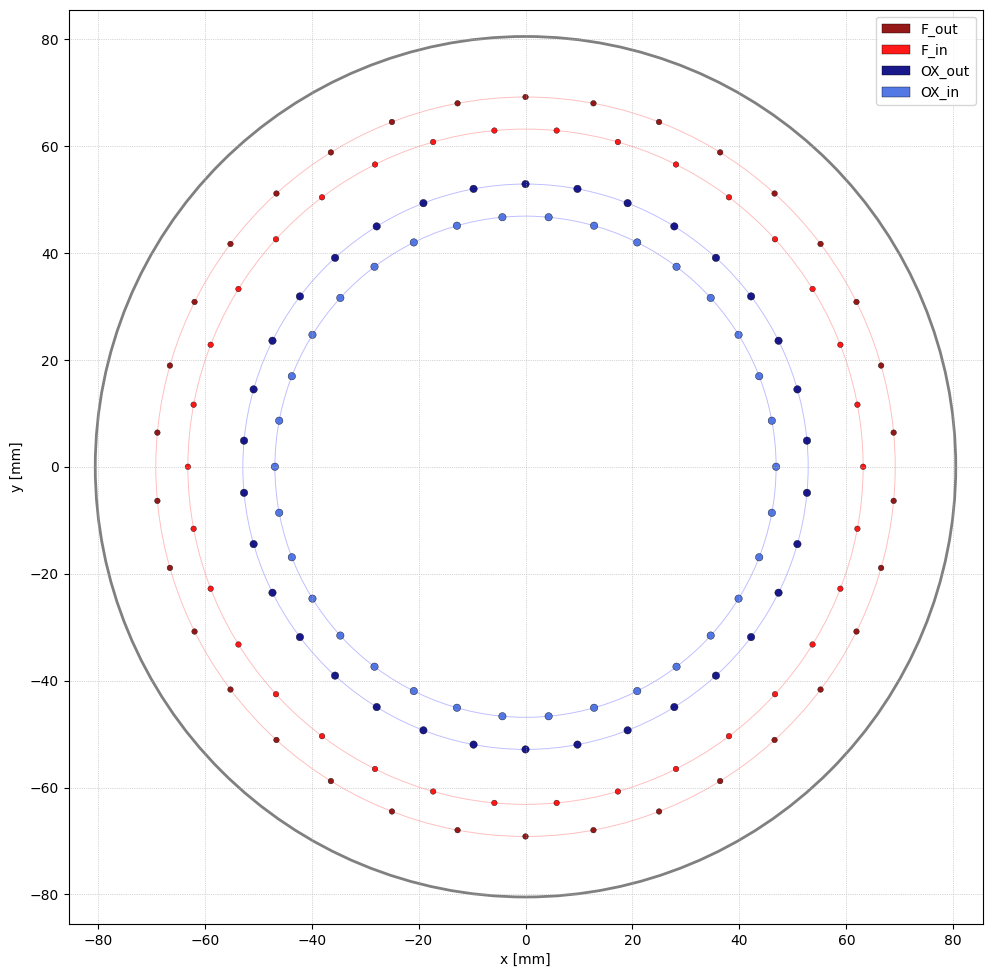

In [ ]:
from matplotlib.patches import Circle

# == PLOTS ==

def ring_points(radius_mm, N, phase_rad=0.0):
    ang = np.linspace(0, 2*np.pi, N, endpoint=False) + phase_rad
    x = radius_mm * np.cos(ang)
    y = radius_mm * np.sin(ang)
    return x, y

def plot_injector_layout_FF_OO_outside_in(
    D_c_mm,
    R_f_in_mm, R_f_out_mm,
    R_ox_in_mm, R_ox_out_mm,
    N_holes, d_f_mm, d_ox_mm,
    stagger_pairs_half_pitch=True,
    margin_extra_mm=5,
    draw_pairs=True
    
):
    # You want: RF,out > F,in > ROX,out > ROX,in  (outside -> inside)
    if not (R_f_out_mm > R_f_in_mm > R_ox_out_mm > R_ox_in_mm):
        raise ValueError(
            "Radii do NOT satisfy your requested ordering (outside→inside):\n"
            "Need: R_f_out > R_f_in > R_ox_out > R_ox_in.\n"
            f"Got (mm): R_f_out={R_f_out_mm:.3f}, R_f_in={R_f_in_mm:.3f}, "
            f"R_ox_out={R_ox_out_mm:.3f}, R_ox_in={R_ox_in_mm:.3f}"
        )

    combRad = D_c_mm / 2.0

    pitch = 2*np.pi / N_holes
    phase_pair1 = 0.0
    phase_pair2 = 0.5*pitch if stagger_pairs_half_pitch else 0.0

    x_f_in,  y_f_in  = ring_points(R_f_in_mm,  N_holes, phase_rad=phase_pair1)
    x_ox_in, y_ox_in = ring_points(R_ox_in_mm, N_holes, phase_rad=phase_pair1)

    x_f_out,  y_f_out  = ring_points(R_f_out_mm,  N_holes, phase_rad=phase_pair2)
    x_ox_out, y_ox_out = ring_points(R_ox_out_mm, N_holes, phase_rad=phase_pair2)

    fig, ax = plt.subplots(figsize=(10, 10))

    # chamber
    ax.add_artist(plt.Circle((0, 0), combRad, color='gray', fill=False, linewidth=2))

    # ring outlines (light)
    for R in [R_f_in_mm, R_f_out_mm]:
        ax.add_artist(plt.Circle((0, 0), R, color='red', fill=False, linewidth=0.7, alpha=0.25))
    for R in [R_ox_in_mm, R_ox_out_mm]:
        ax.add_artist(plt.Circle((0, 0), R, color='blue', fill=False, linewidth=0.7, alpha=0.25))

    # holes
    # draw holes as circles with true diameters (axis units = mm)

    def draw_holes(xs, ys, dia_mm, color, label=None):
        r = dia_mm / 2.0
        first = True
        for x, y in zip(xs, ys):
            lab = label if first and label is not None else None
            circ = Circle((x, y), r, facecolor=color, edgecolor='k', linewidth=0.3, alpha=0.9, label=lab)
            ax.add_patch(circ)
            first = False

    draw_holes(x_f_out,  y_f_out,  d_f_mm,  'darkred',   label='F_out')
    draw_holes(x_f_in,   y_f_in,   d_f_mm,  'red',       label='F_in')
    draw_holes(x_ox_out, y_ox_out, d_ox_mm, 'navy',      label='OX_out')
    draw_holes(x_ox_in,  y_ox_in,  d_ox_mm, 'royalblue', label='OX_in')

    ax.set_aspect('equal', 'box')
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    ax.legend(loc='upper right')
    ax.grid(True, linestyle=':', linewidth=0.5)

    margin = combRad + margin_extra_mm
    ax.set_xlim(-margin, margin)
    ax.set_ylim(-margin, margin)
    plt.tight_layout()
    plt.show()


# --- call ---
holes_per_ring = int(num_holes_lox_inj / Nrings)

plot_injector_layout_FF_OO_outside_in(
    D_c_mm=2*combRad*1e3,
    R_f_in_mm=Rf_inner*1e3,
    R_f_out_mm=Rf_outer*1e3,
    R_ox_in_mm=ROx_inner*1e3,
    R_ox_out_mm=ROx_outer*1e3,
    N_holes=holes_per_ring,
    stagger_pairs_half_pitch=True,
    draw_pairs=True, 
    d_f_mm=diameter_inj_rp1*1e3,
    d_ox_mm=diameter_inj_lox*1e3
)


Holes per ring: 34
Angular pitch: 10.588 deg
Outer-pair stagger: 5.294 deg
Fuel hole diameter: 1.0436 mm  |  Ox hole diameter: 1.3882 mm


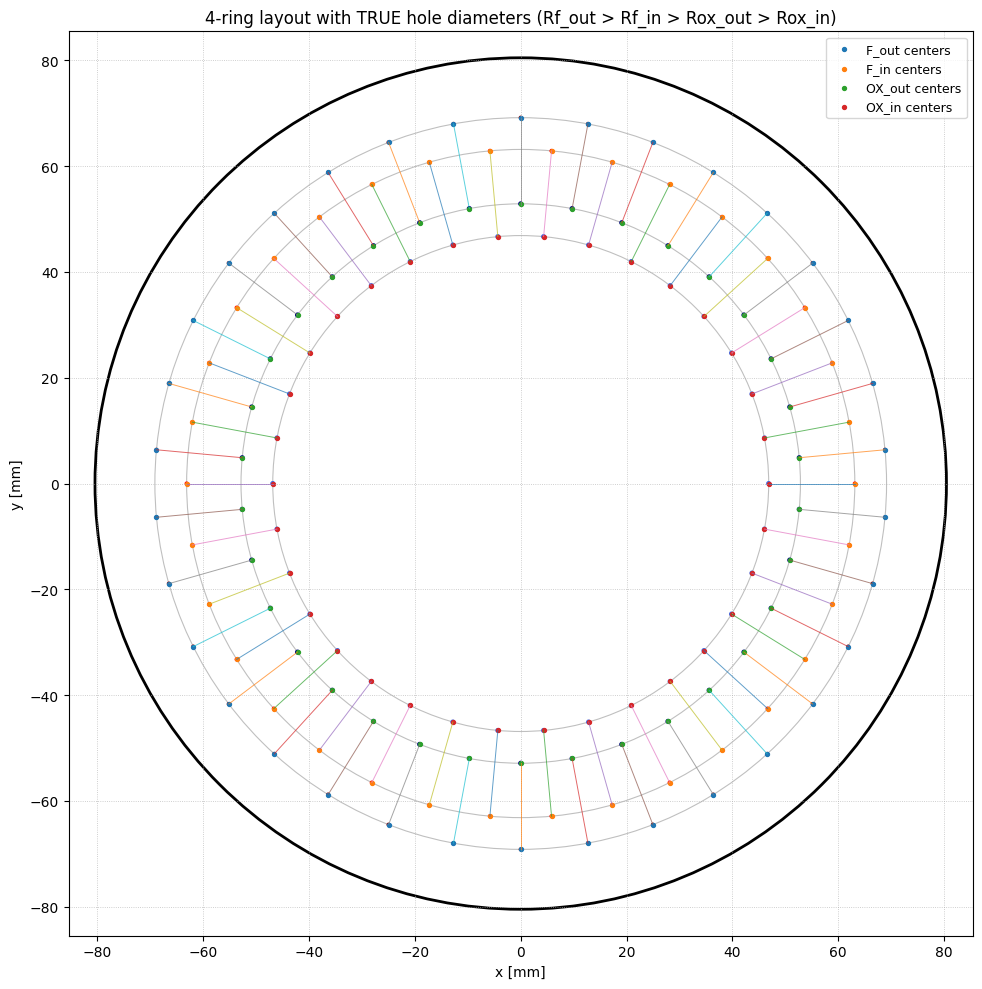

In [ ]:
def ring_points(radius_mm: float, N: int, phase_rad: float = 0.0):
    """Return (x,y) points on a ring at given radius with optional angular phase shift."""
    ang = np.linspace(0, 2*np.pi, N, endpoint=False) + phase_rad
    x = radius_mm * np.cos(ang)
    y = radius_mm * np.sin(ang)
    return x, y, ang

def draw_hole_circles(ax, xs, ys, d_mm, edgecolor):
    """Draw true-size hole circles (diameter d_mm) at provided centers (xs,ys)."""
    r = 0.5 * d_mm
    for x, y in zip(xs, ys):
        ax.add_patch(plt.Circle((x, y), r, fill=True, edgecolor=edgecolor))

def plot_injector_layout_FF_OO_outside_in_TRUEHOLES(
    D_c_mm: float,
    R_f_in_mm: float, R_f_out_mm: float,
    R_ox_in_mm: float, R_ox_out_mm: float,
    N_holes: int,
    d_f_mm: float, d_ox_mm: float,
    stagger_pairs_half_pitch: bool = True,
    margin_extra_mm: float = 5.0,
    draw_pairs: bool = True,
    draw_ring_outlines: bool = True,
    show_centers: bool = True
):
    """
    Plots 4 rings with TRUE hole diameters (to scale) and enforced pairing:
      Pair A: F_in  ↔ OX_in  (same phase)
      Pair B: F_out ↔ OX_out (same phase)

    Enforces ordering outside->inside:
      R_f_out > R_f_in > R_ox_out > R_ox_in
    """

    # --- Validate requested ordering ---
    if not (R_f_out_mm > R_f_in_mm > R_ox_out_mm > R_ox_in_mm):
        raise ValueError(
            "Radii do NOT satisfy requested ordering (outside→inside):\n"
            "Need: R_f_out > R_f_in > R_ox_out > R_ox_in.\n"
            f"Got (mm): R_f_out={R_f_out_mm:.3f}, R_f_in={R_f_in_mm:.3f}, "
            f"R_ox_out={R_ox_out_mm:.3f}, R_ox_in={R_ox_in_mm:.3f}"
        )

    # --- Basic geometry ---
    combRad = D_c_mm / 2.0

    # Angular pitch
    pitch = 2*np.pi / N_holes
    pitch_deg = pitch * 180/np.pi
    half_pitch = 0.5 * pitch

    phase_pair1 = 0.0
    phase_pair2 = half_pitch if stagger_pairs_half_pitch else 0.0

    print(f"Holes per ring: {N_holes}")
    print(f"Angular pitch: {pitch_deg:.3f} deg")
    print(f"Outer-pair stagger: {(0.5*pitch_deg) if stagger_pairs_half_pitch else 0.0:.3f} deg")
    print(f"Fuel hole diameter: {d_f_mm:.4f} mm  |  Ox hole diameter: {d_ox_mm:.4f} mm")

    # --- Compute hole centers ---
    # Pair A: F_in ↔ OX_in (same phase)
    x_f_in,  y_f_in,  _ = ring_points(R_f_in_mm,  N_holes, phase_rad=phase_pair1)
    x_ox_in, y_ox_in, _ = ring_points(R_ox_in_mm, N_holes, phase_rad=phase_pair1)

    # Pair B: F_out ↔ OX_out (same phase, possibly staggered relative to pair A)
    x_f_out,  y_f_out,  _ = ring_points(R_f_out_mm,  N_holes, phase_rad=phase_pair2)
    x_ox_out, y_ox_out, _ = ring_points(R_ox_out_mm, N_holes, phase_rad=phase_pair2)

    # --- Plot setup ---
    fig, ax = plt.subplots(figsize=(10, 10))

    # Chamber circle
    ax.add_patch(plt.Circle((0, 0), combRad, fill=False, linewidth=2))

    # Optional ring outlines (helps debug radii)
    if draw_ring_outlines:
        for R in [R_f_in_mm, R_f_out_mm]:
            ax.add_patch(plt.Circle((0, 0), R, fill=False, linewidth=0.8, alpha=0.25))
        for R in [R_ox_in_mm, R_ox_out_mm]:
            ax.add_patch(plt.Circle((0, 0), R, fill=False, linewidth=0.8, alpha=0.25))

    # Draw TRUE hole circles (to scale)
    draw_hole_circles(ax, x_f_out,  y_f_out,  d_f_mm*0.5,  edgecolor="darkred")
    draw_hole_circles(ax, x_f_in,   y_f_in,   d_f_mm*0.5,  edgecolor="red")
    draw_hole_circles(ax, x_ox_out, y_ox_out, d_ox_mm*0.5, edgecolor="navy")
    draw_hole_circles(ax, x_ox_in,  y_ox_in,  d_ox_mm*0.5, edgecolor="royalblue")

    # Optional center dots so you can see the angular pattern even if holes are tiny
    if show_centers:
        ax.scatter(x_f_out,  y_f_out,  s=8, label="F_out centers")
        ax.scatter(x_f_in,   y_f_in,   s=8, label="F_in centers")
        ax.scatter(x_ox_out, y_ox_out, s=8, label="OX_out centers")
        ax.scatter(x_ox_in,  y_ox_in,  s=8, label="OX_in centers")

    # Pairing lines (sanity check)
    if draw_pairs:
        for i in range(N_holes):
            # Pair A
            ax.plot([x_f_in[i], x_ox_in[i]], [y_f_in[i], y_ox_in[i]], linewidth=0.7, alpha=0.7)
            # Pair B
            ax.plot([x_f_out[i], x_ox_out[i]], [y_f_out[i], y_ox_out[i]], linewidth=0.7, alpha=0.7)

    # Axes
    ax.set_aspect("equal", "box")
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")
    ax.set_title("4-ring layout with TRUE hole diameters (Rf_out > Rf_in > Rox_out > Rox_in)")
    ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.8)
    ax.legend(loc="upper right", fontsize=9)

    # Limits
    margin = combRad + margin_extra_mm
    ax.set_xlim(-margin, margin)
    ax.set_ylim(-margin, margin)

    plt.tight_layout()
    plt.show()


# -----------------------------
# Example call (use YOUR values)
# -----------------------------
# holes_per_ring = int(num_holes_lox_inj / Nrings)

plot_injector_layout_FF_OO_outside_in_TRUEHOLES(
     D_c_mm=2*combRad*1e3,
     R_f_in_mm=Rf_inner*1e3,
     R_f_out_mm=Rf_outer*1e3,
     R_ox_in_mm=ROx_inner*1e3,
     R_ox_out_mm=ROx_outer*1e3,
     N_holes=holes_per_ring,
     d_f_mm=diameter_inj_rp1*1e3,
     d_ox_mm=diameter_inj_lox*1e3,
     stagger_pairs_half_pitch=True,
     draw_pairs=True
 )
